# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

In [36]:
%reload_ext autoreload
%autoreload 2

from plots.chapter2 import plot_losses, plot_resumed_losses

# Rethinking the Training Loop

### Helper Function #1

In [6]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Build function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Set model to TRAIN mode
        model.train()

        # Step 1 - Compute model's predictions - forward pass
        yhat = model(x)

        # Step 2 - Compute the loss
        loss = loss_fn(yhat, y)

        # Step 3 - Compute the gradients for both parameters "b" and "w"
        loss.backward()

        # Step 4 - Update parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()

        # Return the loss
        return loss.item()
    
    return perform_train_step_fn

### Model Configuration V1

In [3]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v0.py

In [4]:
%%writefile model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set learning rate
lr = 0.1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Define an SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Define an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Create the train_step function for model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


In [5]:
%run -i model_configuration/v1.py

In [6]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

### Model Training V1

In [7]:
%%writefile model_training/v1.py

n_epochs = 1000

losses = []

for epoch in range(n_epochs):
    # Perform one train step and return the corresponding loss
    loss = train_step_fn(x_train_tensor.reshape(-1, 1), y_train_tensor.reshape(-1, 1))
    losses.append(loss)

Writing model_training/v1.py


In [8]:
%run -i model_training/v1.py

In [9]:
# Check model's parameters
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0433]], device='cuda:0'), '0.bias': tensor([0.9801], device='cuda:0')})


# Dataset

### Cell 2.1

In [13]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor(0.8446), tensor(2.8032))


## TensorDataset

### Cell 2.2

In [16]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor(0.8446), tensor(2.8032))


## DataLoader

### Cell 2.3

In [18]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [19]:
next(iter(train_loader))

[tensor([0.9193, 0.0778, 0.1196, 0.8696, 0.9593, 0.1396, 0.7629, 0.5147, 0.5059,
         0.3192, 0.7204, 0.9991, 0.0081, 0.6866, 0.9424, 0.5670]),
 tensor([2.9173, 1.2069, 1.2590, 2.9889, 3.0195, 1.3307, 2.4564, 2.1706, 2.0477,
         1.4894, 2.5099, 3.0653, 1.1682, 2.3574, 2.9529, 2.0515])]

### Data Preparation V1

In [25]:
%%writefile data_preparation/v1.py

x_train_tensor = torch.from_numpy(x_train).float().reshape(-1, 1)
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1, 1)

# Build Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Build DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting data_preparation/v1.py


In [26]:
%run -i data_preparation/v1.py

### Model Training V2

In [22]:
%run -i model_configuration/v1.py

In [23]:
%%writefile model_training/v2.py

n_epochs = 1000

losses = []

for epoch in range(n_epochs):
    mini_batch_losses = []

    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches therefore, 
        # we need to send those mini-batches to the device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Perform one train step and return the corresponding loss for this mini-batch
        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)

    losses.append(loss)

Writing model_training/v2.py


In [27]:
%run -i model_training/v2.py

In [28]:
# Check model's parameters
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0428]], device='cuda:0'), '0.bias': tensor([0.9785], device='cuda:0')})


## Mini-Batch Inner Loop

### Helper Function #2

In [7]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []

    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)

    return loss

### Model Training V3

In [30]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py

In [31]:
%%writefile model_training/v3.py

n_epochs = 200

losses = []

for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Writing model_training/v3.py


In [32]:
%run -i model_training/v3.py

In [33]:
# Check model's parameters
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0412]], device='cuda:0'), '0.bias': tensor([0.9759], device='cuda:0')})


## Random Split

### Data Preparation V2

In [34]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Build tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float().reshape(-1, 1)
y_tensor = torch.from_numpy(y).float().reshape(-1, 1)

# Build dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Perform split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Build a loader for each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Writing data_preparation/v2.py


In [37]:
%run -i data_preparation/v2.py

# Evaluation

### Helper Function #3

In [8]:
def make_val_step_fn(model, loss_fn):
    # Build function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Set model to EVAL mode
        model.eval()

        # Step 1 - Compute model's predictions - forward pass
        yhat = model(x)

        # Step 2 - Compute the loss
        loss = loss_fn(yhat, y)

        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()

    return perform_val_step_fn

### Model Configuration V2

In [39]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set learning rate
lr = .1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Define an SGD optimizer to update the parameters retrieved from the model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

# Create the train_step function for model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Create the val_step function model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Writing model_configuration/v2.py


In [40]:
%run -i model_configuration/v2.py

### Model Training V4

In [41]:
%%writefile model_training/v4.py

n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

Writing model_training/v4.py


In [42]:
%run -i model_training/v4.py

In [43]:
# Check model's parameters
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0195]], device='cuda:0'), '0.bias': tensor([1.0024], device='cuda:0')})


## Plotting Losses

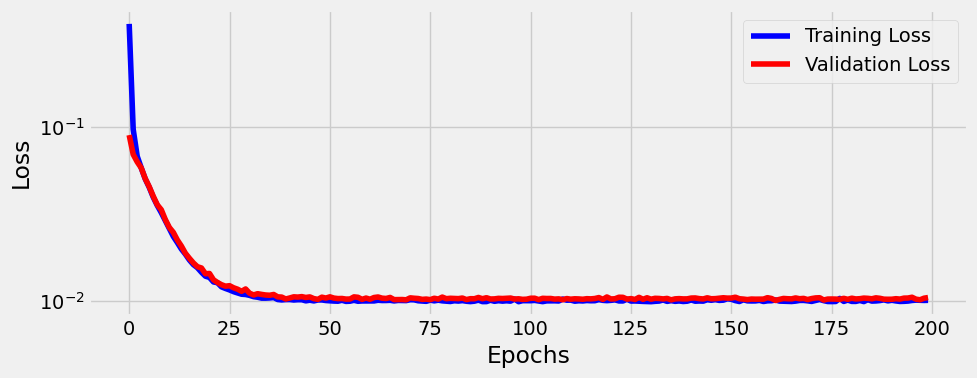

In [47]:
fig = plot_losses(losses, val_losses)

# TensorBoard

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [14]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 34129), started 0:31:38 ago. (Use '!kill 34129' to kill it.)

## SummaryWriter

In [4]:
writer = SummaryWriter('runs/test')  # from torch.utils.tensorboard import SummaryWriter

In [9]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py
%run -i model_configuration/v2.py
%run -i model_training/v4.py

In [10]:
writer.add_graph(model)

example_kwarg_inputs should be a dict
Error occurs, No graph saved


RuntimeError: example_kwarg_inputs should be a dict

In [11]:
# Fetch a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data.
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

## add_scalars

In [13]:
writer.add_scalars(
    main_tag='loss', 
    tag_scalar_dict={'training': loss, 'validation': val_loss}, 
    global_step=epoch,
)

### Model Configuration V3

In [17]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = .1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

val_step_fn = make_val_step_fn(model, loss_fn)

# Create a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetch a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Overwriting model_configuration/v3.py


In [18]:
%run -i model_configuration/v3.py

### Model Training V5

In [19]:
%%writefile model_training/v5.py

n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

    # Record both losses for each epoch under the main tag "loss"
    writer.add_scalars(
        main_tag='loss',
        tag_scalar_dict={'training': loss, 'validation': val_loss},
        global_step=epoch,
    )

# Close the writer
writer.close()

Writing model_training/v5.py


In [20]:
%run -i model_training/v5.py

In [21]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0169]], device='cuda:0'), '0.bias': tensor([0.9978], device='cuda:0')})


In [22]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 34129), started 0:49:57 ago. (Use '!kill 34129' to kill it.)

# Saving and Loading Models

## Saving

### Cell 2.4

In [25]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'losses': losses,
              'val_losses': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

## Resuming Training

### Cell 2.5

In [26]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

In [27]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]], device='cuda:0'), '0.bias': tensor([0.8300], device='cuda:0')})


### Cell 2.6

In [28]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['losses']
saved_val_losses = checkpoint['val_losses']

model.train()  # always use TRAIN for resuming training

/tmp/ipykernel_34025/23490277.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')


Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [29]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0169]], device='cuda:0'), '0.bias': tensor([0.9978], device='cuda:0')})


### Cell 2.7

In [31]:
%run -i model_training/v5.py

In [32]:
print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0169]], device='cuda:0'), '0.bias': tensor([0.9978], device='cuda:0')})


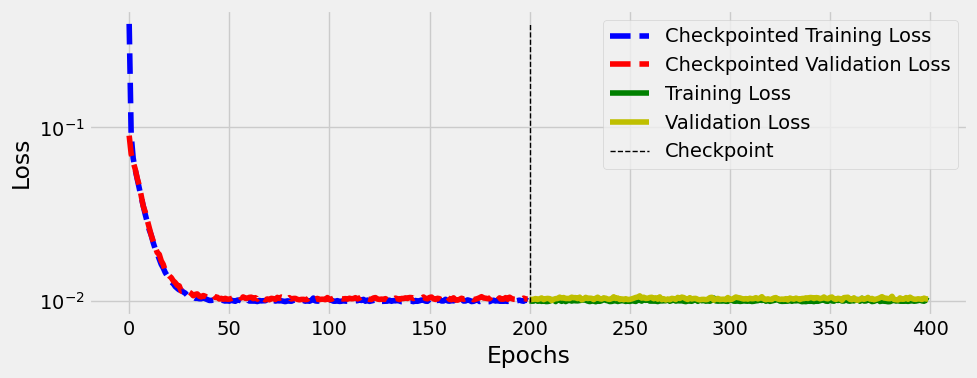

In [37]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

## Deploying / Making Predictions

### Cell 2.8

In [38]:
%run -i model_configuration/v3.py

### Cell 2.9

In [39]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

print(model.state_dict())

OrderedDict({'0.weight': tensor([[2.0169]], device='cuda:0'), '0.bias': tensor([0.9978], device='cuda:0')})


/tmp/ipykernel_34025/3137571511.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')


### Cell 2.10

In [40]:
new_inputs = torch.tensor([[.20], [.34], [.57]]).to(device)

model.eval()  # always use EVAL for fully trained models
model(new_inputs)

tensor([[1.4012],
        [1.6835],
        [2.1474]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Putting It All Together

In [ ]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Build tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float().reshape(-1, 1)
y_tensor = torch.from_numpy(y).float().reshape(-1, 1)

# Build dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Perform split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Build a loader for each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [ ]:
# %load model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = .1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 1)).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

val_step_fn = make_val_step_fn(model, loss_fn)

# Create a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetch a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

In [ ]:
# %load model_training/v5.py

n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

    # Record both losses for each epoch under the main tag "loss"
    writer.add_scalars(
        main_tag='loss',
        tag_scalar_dict={'training': loss, 'validation': val_loss},
        global_step=epoch,
    )

# Close the writer
writer.close()

In [ ]:
print(model.state_dict())

### Weird plots in TensorBoard?

Run this if you want to clean up a previous run and start fresh with TensorBoard :-)

In [ ]:
import shutil

shutil.rmtree('./runs/simple_linear_regression/', ignore_errors=True)